In [1]:
# imports

import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

In [2]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
from collections import Counter

In [3]:
import json

In [4]:
# Turn off warnings
import warnings

warnings.filterwarnings('ignore')

## Preprocessing

In [5]:
# loading the two datasets 

ratings_ba_df = pd.read_csv('data/BeerAdvocate/ratings_BA.csv')
ratings_rb_df = pd.read_csv('data/RateBeer/ratings_RB.csv')


# loading the users dataset 

users_ba_df = pd.read_csv('data/BeerAdvocate/users.csv')
users_rb_df = pd.read_csv('data/RateBeer/users.csv')

# loading the beers dataset

beers_ba_df = pd.read_csv('data/BeerAdvocate/beers.csv')
beers_rb_df = pd.read_csv('data/RateBeer/beers.csv')

In [6]:
# Convert the date column to datetime format for BeerAdvocate
ratings_ba_df['date'] = pd.to_datetime(ratings_ba_df['date'], unit='s')
ratings_ba_df['year'] = ratings_ba_df['date'].dt.year
ratings_ba_df['month'] = ratings_ba_df['date'].dt.month

# Convert the date column to datetime format for RateBeer
ratings_rb_df['date'] = pd.to_datetime(ratings_rb_df['date'], unit='s')
ratings_rb_df['year'] = ratings_rb_df['date'].dt.year
ratings_rb_df['month'] = ratings_rb_df['date'].dt.month

## Filter on location

In [7]:
users_rb_df['location'] = users_rb_df['location'].str.split(',').str[0]
users_ba_df['location'] = users_ba_df['location'].str.split(',').str[0]

US_country = 'United States'

# keep only the rows where the user country is United States
users_ba_df = users_ba_df[users_ba_df.location == US_country]
users_rb_df = users_rb_df[users_rb_df.location == US_country]

# merge the ratings and users data frames to get the location of the user for each rating
ratings_users_ba_df = pd.merge(ratings_ba_df, users_ba_df[['user_id', 'location']], on='user_id', how='inner')
ratings_users_rb_df = pd.merge(ratings_rb_df, users_rb_df[['user_id', 'location']], on='user_id', how='inner')

# filter the ratings dataframes to only keep the popular ratings of the users from the US
ratings_ba_df = ratings_users_ba_df[ratings_users_ba_df.location == US_country]
ratings_ba_df.drop('location', axis=1, inplace=True)
ratings_rb_df = ratings_users_rb_df[ratings_users_rb_df.location == US_country]
ratings_rb_df.drop('location', axis=1, inplace=True)

## Separate the good ratings and bad ratings

In [8]:
mean_ba = ratings_ba_df.rating.mean()
mean_rb = ratings_rb_df.rating.mean()

print("Mean rating in BeerAdvocate:", mean_ba)
print("Mean rating in RateBeer:", mean_rb)

Mean rating in BeerAdvocate: 3.846906563579535
Mean rating in RateBeer: 3.3793541115704993


In [12]:
ratings_ba_df_untouched = ratings_ba_df.copy()
ratings_rb_df_untouched = ratings_rb_df.copy()

# Filter the ratings dataframes to only keep the popular ratings
good_ratings_ba_df = ratings_ba_df[ratings_ba_df['rating'] > mean_ba]
good_ratings_rb_df = ratings_rb_df[ratings_rb_df['rating'] > mean_rb]

bad_ratings_ba_df = ratings_ba_df[ratings_ba_df['rating'] <= mean_ba]
bad_ratings_rb_df = ratings_rb_df[ratings_rb_df['rating'] <= mean_rb]

In [13]:
# merge the two ratings data frames
good_ratings_combined_df = pd.concat([good_ratings_ba_df, good_ratings_rb_df], ignore_index=True)
bad_ratings_combined_df = pd.concat([bad_ratings_ba_df, bad_ratings_rb_df], ignore_index=True)

combinde_ratings_df = pd.concat([ratings_ba_df_untouched, ratings_rb_df_untouched], ignore_index=True)

## How to consider the most popular beer for each category ? 

In [14]:
# group by beer_id and compute the average aroma and the number of ratings for each beer
beer_rating_df = combinde_ratings_df.groupby('beer_id').agg({'rating': 'mean', 'beer_id': 'count'})
beer_rating_df.rename(columns={'beer_id': 'count'}, inplace=True)
beer_rating_df.reset_index(inplace=True)

beer_rating_df.sort_values(by=['count', 'rating'], ascending=False, inplace=True)
beer_rating_df

,beer_id,rating,count
665,680,4.131435,5497
1048,1093,4.027117,4551
402,412,3.790415,4168
1049,1094,3.856541,3854
2001,2093,4.233636,3727
...,...,...,...
226319,326701,0.500000,1
277088,452975,0.500000,1
277097,453009,0.500000,1
277102,453017,0.500000,1


The problem here is, what should we consider as popular? 
If we consider only the average rating, we could have a beer with a rating of 10 but with only 1 review. This does not represent the popularity we are looking for. 

Let's display a similar dataframe for the rating of each attribute: taste, appearance, aroma and palate.

In [15]:
def get_best_beers(df, attribute, n=10):
    """Return the n best beers from the dataframe"""
    beer_rating_df = df.groupby('beer_id').agg({attribute: 'mean', 'beer_id': 'count'})
    beer_rating_df.rename(columns={'beer_id': 'count'}, inplace=True)
    beer_rating_df.reset_index(inplace=True)

    beer_rating_df.sort_values(by=['count', attribute], ascending=False, inplace=True)
    
    # print the 10 best beers ids
    print(beer_rating_df.head(n))

We observe that the top 10 beers are the same throughout the categories, because the count of the reviews is preferred over the average rating, eventhough we observe different average rating from the different attributes. Thus, the sorting should be more balanced between the number of ratings and the average rating.

To correctly rank the beers, we will consider the lower bound of Wilson score. 
Wilson lower bound score presents the usefulness value of a product/comment to the user with a 95% confidence interval (https://medium.com/@okanckaya/rating-products-sorting-reviews-aff32cbd29c1).

Here we will consider as negative ratings (i.e bad ratings) the number of ratings that are below the average rating. And we will consider as positive rating (i.e. good rating) the number of ratings that are above the average. 

In [16]:
import math
import scipy.stats as st

def wilson_lower_bound (pos, neg, confidence=0.95):
    n = pos + neg
    if n == 0:
        return 0
    z = st.norm.ppf(1 - (1 - confidence) / 2)
    phat = 1.0 * pos / n
    return (phat + z * z / (2 * n) - z * math. sqrt ((phat * (1 - phat) + z * z / (4 * n)) / n)) / (1 + z * z / n)

Let's rank the beers by computing the Wilson lower bound for each beer. 

In [17]:
# print the average rating for the dataframe 
average_rating = combinde_ratings_df['rating'].mean()
print("Average rating:", average_rating)

Average rating: 3.5804573424896784


In [18]:
beer_rating_df = combinde_ratings_df.copy()

beer_rating_df['above_average'] = beer_rating_df['rating'] > average_rating
beer_rating_df['below_average'] = beer_rating_df['rating'] <= average_rating

# group by beer_id and compute the average rating and the number of ratings for each beer
beer_rating_df = beer_rating_df.groupby('beer_id').agg({'rating': 'mean', 'beer_id': 'count', 'above_average': 'sum', 'below_average': 'sum'})
beer_rating_df.rename(columns={'rating': 'average_rating', 'beer_id': 'count'}, inplace=True)
beer_rating_df.reset_index(inplace=True)

# compute the lower bound for the average rating
beer_rating_df['lower_bound'] = beer_rating_df.apply(lambda row: wilson_lower_bound(row['above_average'], row['below_average']), axis=1)

# sort the dataframe by the lower bound
beer_rating_df.sort_values(by='lower_bound', ascending=False, inplace=True)

# print the 10 best beers ids
print(beer_rating_df.head(10))

       beer_id  average_rating  count  above_average  below_average  \
74811    86237        4.685437    664            661              3   
19626    21690        4.690985    934            928              6   
97243   115317        4.689776    312            311              1   
50780    58299        4.579204    377            375              2   
7461      7971        4.598017   3662           3604             58   
54187    62397        4.675419    334            332              2   
1484      1545        4.628038   1626           1602             24   
32643    37265        4.495938    650            643              7   
98246   116684        4.435559    322            320              2   
68899    79387        4.501307    153            153              0   

       lower_bound  
74811     0.986801  
19626     0.986056  
97243     0.982071  
50780     0.980866  
7461      0.979581  
54187     0.978433  
1484      0.978131  
32643     0.977939  
98246     0.977640  
68899   

In [21]:
# print the name of the beer with the highest lower bound of the confidence interval
beer_id = beer_rating_df.iloc[0]['beer_id']
beer_name = combinde_ratings_df[combinde_ratings_df['beer_id'] == beer_id].iloc[0]['beer_name']
print("The beer with the highest lower bound of the confidence interval is:", beer_name)

The beer with the highest lower bound of the confidence interval is: Julius


We clearly observe that the ranking is not the same as initially done.

Let's create a function that we will use to find out the most popular beer for a rating. 

In [45]:
def get_wilson_beers(df, attribute, n=10, bad=False):
    # bad is a boolean to decide whether we want the bad ratings.
    average_rating = df[attribute].mean()
    
    beer_rating_df = df.copy()

    beer_rating_df['above_average'] = beer_rating_df[attribute] > average_rating
    beer_rating_df['below_average'] = beer_rating_df[attribute] <= average_rating

    beer_rating_df = beer_rating_df.groupby('beer_id').agg({attribute: 'mean', 'beer_id': 'count', 'above_average': 'sum', 'below_average': 'sum'})
    beer_rating_df.rename(columns={'beer_id': 'count'}, inplace=True)
    beer_rating_df.reset_index(inplace=True)
    
    # compute the lower bound of the confidence interval for each beer
    beer_rating_df['lower_bound'] = beer_rating_df.apply(lambda row: wilson_lower_bound(row['above_average'], row['below_average']), axis=1)
    
    # sort by the lower bound of the confidence interval
    beer_rating_df.sort_values(by=['lower_bound'], ascending=bad, inplace=True)
    
    # select the top n beers
    beer_rating_df = beer_rating_df.head(n)
    
    print(beer_rating_df)
    
    return beer_rating_df.beer_id.values

Let's observe the ranking of the beers by sorting the ratings by the lower bound of Wilson. 

In [23]:
# for taste
print("Best beers for taste:")
taste_beer_ids = get_wilson_beers(combinde_ratings_df, 'taste', n=10)

# for aroma
print("Best beers for aroma:")
aroma_beer_ids = get_wilson_beers(combinde_ratings_df, 'aroma', n=10)

# for appearance
print("Best beers for appearance:")
appearance_beer_ids = get_wilson_beers(combinde_ratings_df, 'appearance', n=10)

# for palate
print("Best beers for palate:")
palate_beer_ids = get_wilson_beers(combinde_ratings_df, 'palate', n=10)


Best beers for taste:
        beer_id     taste  count  above_average  below_average  lower_bound
92879    109078  7.661069    655            654              1     0.991403
108150   131594  7.911765    306            306              0     0.987602
4627       4934  8.952813   1653           1639             14     0.985834
129863   165181  8.178707    263            263              0     0.985604
90597    105767  8.351706    381            380              1     0.985285
101955   122097  8.396825    252            252              0     0.984985
57170     65881  8.119417   1030           1022              8     0.984749
13091     14232  8.563501   1874           1855             19     0.984219
50580     58057  8.937778    225            225              0     0.983213
57808     66624  8.227931    759            753              6     0.982862
Best beers for aroma:
        beer_id     aroma  count  above_average  below_average  lower_bound
53227     61167  8.028953    449            

KeyboardInterrupt: 

## Attribute analysis

In [88]:
# drop rows where there are null values for taste, aroma, appearance, palate
combinde_ratings_df.dropna(inplace=True)

In [89]:
# Calculate correlation coefficients
correlation_matrix = combinde_ratings_df[['rating', 'taste', 'aroma', 'appearance', 'palate']].corr()

# Print the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Extract correlations with overall rating
overall_correlations = correlation_matrix['rating'].drop('rating')

# Print correlations with overall rating
print("\nCorrelations with Overall Rating:")
print(overall_correlations)

# Identify which attribute has the highest correlation
max_corr_attribute = overall_correlations.idxmax()
print("\nThe attribute with the highest correlation with Overall Rating:", max_corr_attribute)


Correlation Matrix:
              rating     taste     aroma  appearance    palate
rating      1.000000  0.313639  0.274070    0.661040  0.790602
taste       0.313639  1.000000  0.896132    0.135081  0.208878
aroma       0.274070  0.896132  1.000000    0.132816  0.145018
appearance  0.661040  0.135081  0.132816    1.000000  0.593588
palate      0.790602  0.208878  0.145018    0.593588  1.000000

Correlations with Overall Rating:
taste         0.313639
aroma         0.274070
appearance    0.661040
palate        0.790602
Name: rating, dtype: float64

The attribute with the highest correlation with Overall Rating: palate


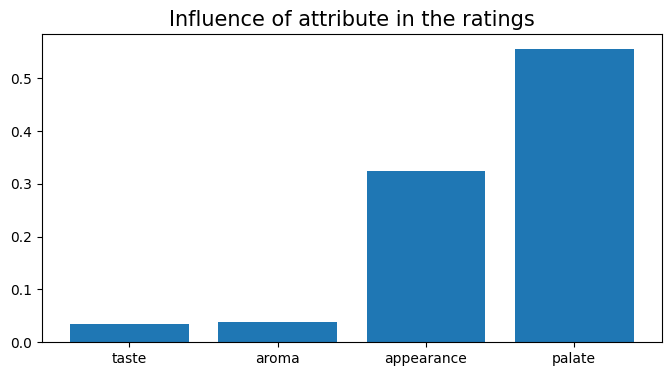

                                 OLS Regression Results                                
Dep. Variable:                 rating   R-squared (uncentered):                   0.989
Model:                            OLS   Adj. R-squared (uncentered):              0.989
Method:                 Least Squares   F-statistic:                          1.237e+08
Date:                Mon, 11 Dec 2023   Prob (F-statistic):                        0.00
Time:                        19:10:21   Log-Likelihood:                     -2.4352e+06
No. Observations:             5419565   AIC:                                  4.870e+06
Df Residuals:                 5419561   BIC:                                  4.870e+06
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [94]:
from sklearn import linear_model
import statsmodels.api as sm

X = combinde_ratings_df[['taste', 'aroma', 'appearance', 'palate']]
y = combinde_ratings_df['rating']


clf = linear_model.LinearRegression(fit_intercept=False)
clf.fit(X, y)
weights = clf.coef_
plt.figure(figsize = (8, 4))
plt.bar(x = ['taste', 'aroma', 'appearance', 'palate'], height = weights)
plt.title('Influence of attribute in the ratings', fontsize=15)
plt.grid(False)
plt.show()

ols = sm.OLS(y, X)
model = ols.fit()

print(model.summary())

We observe that the attribute palate has the most substantial consequence on the rating, followed by appearance, aroma and taste.
Let's take a look now at the good reviews.

## Textual analysis

In [33]:
nlp = spacy.load('en_core_web_sm')

In [25]:
# drop rows where text is missing
good_ratings_combined_df.dropna(subset=['text'], inplace=True)
bad_ratings_combined_df.dropna(subset=['text'], inplace=True)

## Attribute analysis 

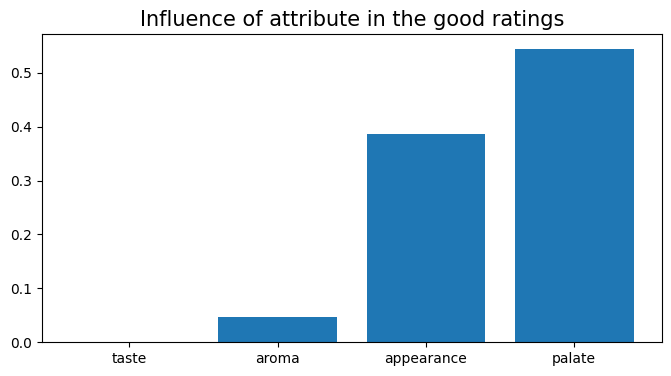

In [95]:
X = good_ratings_combined_df[['taste', 'aroma', 'appearance', 'palate']]
y = good_ratings_combined_df['rating']


clf = linear_model.LinearRegression(fit_intercept=False)
clf.fit(X, y)
weights = clf.coef_
plt.figure(figsize = (8, 4))
plt.bar(x = ['taste', 'aroma', 'appearance', 'palate'], height = weights)
plt.title('Influence of attribute in the good ratings', fontsize=15)
plt.grid(False)
plt.show()

ols = sm.OLS(y, X)
model = ols.fit()

We get the same result as before. To have more insights, let's look at the seasonality of the attributes. Do we observe any difference between the different months? 

## Attribute analysis by months

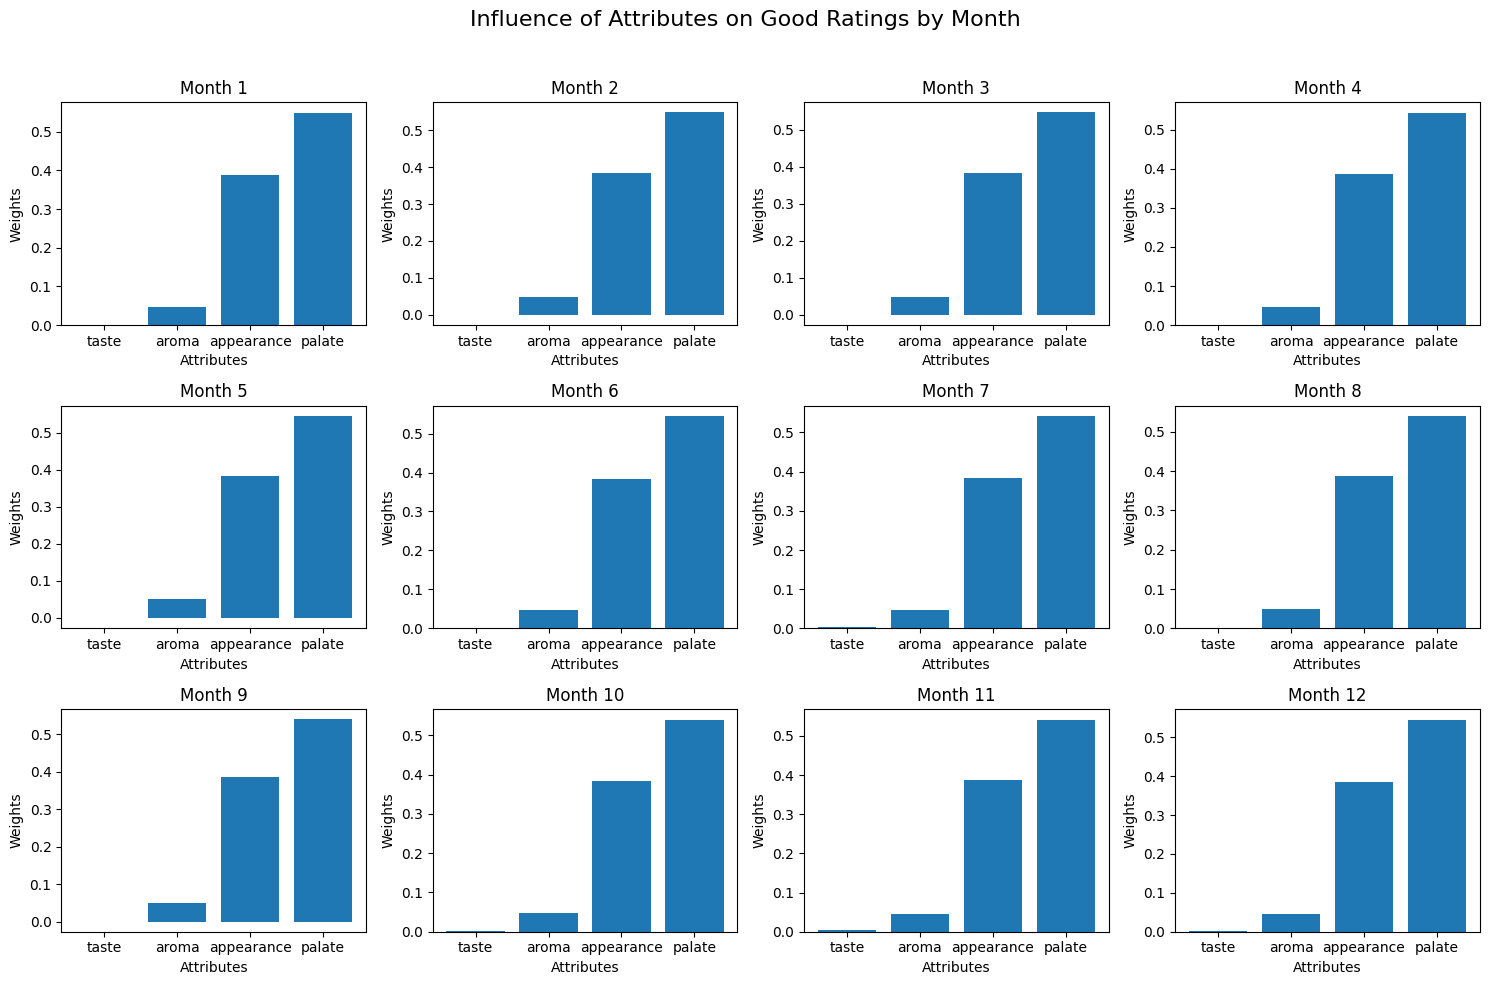

In [96]:
# List of months
months = sorted(good_ratings_combined_df['month'].unique())

# Set up subplots
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
fig.suptitle('Influence of Attributes on Good Ratings by Month', fontsize=16)

# Flatten the 3x4 subplot grid into a 1D array for iteration
axes = axes.flatten()

for i, month in enumerate(months):
    # Filter data for the current month
    month_df = good_ratings_combined_df[good_ratings_combined_df['month'] == month]
    
    # Define X and y for the current month
    X = month_df[['taste', 'aroma', 'appearance', 'palate']]
    y = month_df['rating']

    # Linear Regression
    clf = linear_model.LinearRegression(fit_intercept=False)
    clf.fit(X, y)
    weights = clf.coef_

    # Create a bar plot on the current subplot
    axes[i].bar(x=['taste', 'aroma', 'appearance', 'palate'], height=weights)
    axes[i].set_title(f'Month {month}')
    axes[i].set_xlabel('Attributes')
    axes[i].set_ylabel('Weights')
    axes[i].grid(False)

# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [24]:
# keep only the keywords that appear more than 100 times
#appearance_dict = {k: v for k, v in appearance_dict.items() if v > 100}

# list of words to remove from the dictionary
appearance_terms = ['white', 'brown', 'light', 'small', 'thin', 'dark', 'golden', 'retention', 'medium', 'hazy', 'clear', 
                            'amber', 'black', 'creamy', 'thick', 'beige', 'orange', 'yellow', 'tan', 'foamy', 'copper', 'big', 
                            'gold', 'decent', 'deep', 'cloudy', 'lace', 'moderate', 'red', 'minimal', 
                            'ring', 'bright', 'colored', 'straw', 'dense', 'reddish', 'pale', 'khaki', 
                            'slight', 'rich', 'huge', 'fizzy', 'frothy', 'solid', 'average', 
                            'short', 'bubble', 'caramel', 'soft', 'pink', 'mocha', 'opaque', 'murky', 'ruby',
                            'rocky', 'fine', 'cling', 'cap', 'mahogany', 'brownish', 'ton', 'hue',  
                            'haze', 'pitch', 'clarity', 'wispy', 'cherry', 'highlight', 'clean', 'fade', 'funky', 
                            'ivory', 'purple', 'lacy', 'bone', 'high', 'hint', 'pinkish', 'peach', 'toffee',  'yellowish', 
                            'patchy', 'bronze', 'muddy', 'firm', 'clingy', 'stringy', 'visible', 'transparent']

In [25]:
#taste_dict = {k: v for k, v in taste_dict.items() if v > 100}

taste_terms = ['sweet',  'bitter', 'smooth', 'roasted', 'dry', 'fruity', 'tart', 'bodied', 
    'bitterness', 'sour', 'strong', 'spice', 'mild', 'rich',  'yeast', 'profile', 'sweetness', 'earthy', 'balanced', 'alcohol', 
    'wheat', 'spicy', 'clean', 'moderate', 'crisp', 'grain', 'slight', 'heavy',
    'creamy', 'mid', 'complex', 'hint', 'roasty', 'bready', 'bread', 'roast', 'herbal', 'fresh', 'sugar', 'balance', 
    'solid', 'soft', 'juicy', 'subtle', 'grass', 'grassy', 'smoke',
    'funk', 'nutty', 'character', 'refreshing', 'citrusy', 'belgian', 'decent', 'bittersweet', 
    'rye', 'thick', 'thin', 'piney', 'grainy', 'clove', 'yeasty', 
    'wine', 'molasse', 'ale', 'biscuit', 'funky', 'bud', 'plenty', 'peppery', 'milk', 'barrel', 'tartness', 
    'smoky', 'woody', 'faint', 'toast', 'low', 'stout', 
    'ester', 'ton', 'bold', 'intense', 'deep', 'suit', 'brew', 'tangy', 'whiskey', 'blend', 'peel', 
    'tasty', 'ipa', 'acidic', 'straw', 'boozy', 'fruitiness', 'smokey', 'mellow', 'earthiness', 'juice', 'toasty', 'booze', 
    'average', 'tone', 'dough', 'robust', 'sourness', 'cracker', 'noticeable', 'biscuity', 
    'rind', 'barley', 'lager', 'cream', 'plum', 'acidity',  'hoppiness', 'upfront', 
    'resinous', 'syrup', 'porter', 'vinegar', 'sugary',' bubblegum']


In [37]:
#palate_dict = {k: v for k, v in palate_dict.items() if v > 100}

palate_terms = ['medium', 'light', 'smooth', 'creamy', 'dry', 'bodied', 'soft', 'thin', 'thick', 'moderate', 'crisp',  'sticky', 'slick', 
                'mid', 'solid', 'decent', 'mild', 'balanced', 'oily', 'chewy', 'deep', 'watery', 'silky', 'refreshing', 'strong', 'touch', 'balance', 'fizzy', 'character', 
                'fine', 'flat', 'full', 'hint', 'sharp', 'bready', 'foamy', 'viscous', 'chalky', 'effervescent', 'fluffy', 'grainy', 'gentle', 
                'prickly', 'tartness', 'bubbly', 'acidic', 'astringency']

In [27]:
#aroma_dict = {k: v for k, v in aroma_dict.items() if v > 100}

aroma_terms = ['citrus', 'chocolate', 'fruit', 'fruity', 'coffee',  'floral',
    'caramel', 'pine', 'grapefruit', 'tropical', 'vanilla', 'lemon', 'bourbon', 'cherry', 
    'orange', 'herbal', 'decent', 'citrusy', 'cocoa', 'honey', 'oak', 
    'toffee', 'nutty', 'banana', 'grass', 'apple', 
    'pepper', 'pineapple', 'thin', 'funk', 'clove', 'wood', 
    'berry', 'woody', 'biscuit', 'raspberry', 'grape', 'molasse', 'tangy', 'barrel', 'peach', 'raisin', 'resinous', 
    'candy', 'ipa',  'nut', 'pungent', 'pumpkin', 'ginger', 
    'mango', 'warming', 'earth', 'mellow', 'cereal', 'ring', 'astringent', 
    'coriander', 'tangerine', 'maple', 'melon', 'hay', 'lactic', 'citric', 'peel', 'rind', 'lager', 'bold', 'vinous', 'weak', 'toasted', 'blueberry', 
    'biscuity', 'spiced', 'lime', 'metallic', 'coconut', 'hay'
]

## Using the lower bound of Wilson to select the best beer

In [31]:
def matching_keywords(text, list_keywords):
    # Process the text with spaCy
    doc = nlp(text.lower())

    result = []
    for token in doc:
        token = token.lemma_
        if token in list_keywords:
            result.append(token)
    
    return result

In [47]:
def find_top_keywords_by_month(df, keywords_list, month, category, num_keywords, bad=False):
    # Filter the DataFrame for the specified month
    # bad is a boolean to determine whether we want good or bad beer.By default we consider the good beers
    
    month_df = df[df['month'] == month]

    # Find the best beer for the month based on average rating and review count
    #best_beer_df = month_df.groupby('beer_id').agg({category: ['mean', 'count']}).reset_index()
    #best_beer_df.columns = ['beer_id', 'average_rating', 'review_count']
    #beer_stats = best_beer_df.sort_values(by=['review_count', 'average_rating'], ascending=[False, False])

    # Get the beer ID of the best beer for the month
    #best_beer_id = beer_stats.iloc[0]['beer_id']
    
    beer_ids = get_wilson_beers(month_df, category, n=10, bad=bad)
    
    # print the best beer id for the month
    #print(f"Best beer for the month of {month}:", best_beer_id)

    # filter the dataframe with the 10 best/worst beers for the month
    beer_reviews = month_df[month_df['beer_id'].isin(beer_ids)]

    # Extract keywords from reviews using a matching function (e.g., matching_keywords)
    keyword_list = []
    for text in beer_reviews['text'].values.tolist():
        keyword_list.extend(matching_keywords(text, keywords_list))

    # Count the number of times each keyword appears in the reviews
    keyword_counter = Counter(keyword_list)

    # Sort the dictionary by value
    sorted_keywords = dict(sorted(keyword_counter.items(), key=lambda item: item[1], reverse=True))

    # Return the top N keywords as a list of tuples (key, value)
    top_keywords = [(key, sorted_keywords[key]) for key in list(sorted_keywords.keys())[:num_keywords]]

    return top_keywords

## Aroma analysis 

In [34]:
# for each month, find the top 10 keywords, FOR GOOD BEERS
top_keywords_by_month = {}
for month in range(1, 13):
    top_keywords_by_month[month] = find_top_keywords_by_month(good_ratings_combined_df, aroma_terms, month, 'aroma', 10)
    #print("Month", month)
    #print(top_keywords_by_month[month])
    #print()

       beer_id     aroma  count  above_average  below_average  lower_bound
4425      8909  8.500000    266            266              0     0.985764
1733      2530  8.137795    254            254              0     0.985101
12356    42303  7.906863    204            204              0     0.981517
2811      4934  8.767442    172            172              0     0.978154
12170    41297  7.765517    145            145              0     0.974191
5124     11243  7.916667    264            262              2     0.972804
17475    64102  8.014599    137            137              0     0.972725
21478    81812  8.465385    260            258              2     0.972392
5889     14138  7.968504    127            127              0     0.970640
5072     11047  7.685039    127            127              0     0.970640
Best beer for the month of 1: [ 8909  2530 42303  4934 41297 11243 64102 81812 14138 11047]
       beer_id     aroma  count  above_average  below_average  lower_bound
4293    

       beer_id     aroma  count  above_average  below_average  lower_bound
6103     14396  8.094737     95             95              0     0.961135
6061     14232  8.576923    130            129              1     0.957715
13696    48429  8.075472    106            105              1     0.948486
1730      2528  7.567164     67             67              0     0.945774
8535     25082  8.020134    149            146              3     0.942481
6835     17385  8.229508     61             61              0     0.940756
1732      2530  8.105556    180            175              5     0.936632
20223    77640  8.194611    334            321             13     0.934555
25739   105767  8.370370     54             54              0     0.933586
4483      8936  8.570588    170            165              5     0.933006
Best beer for the month of 10: [ 14396  14232  48429   2528  25082  17385   2530  77640 105767   8936]
       beer_id     aroma  count  above_average  below_average  lower_bou

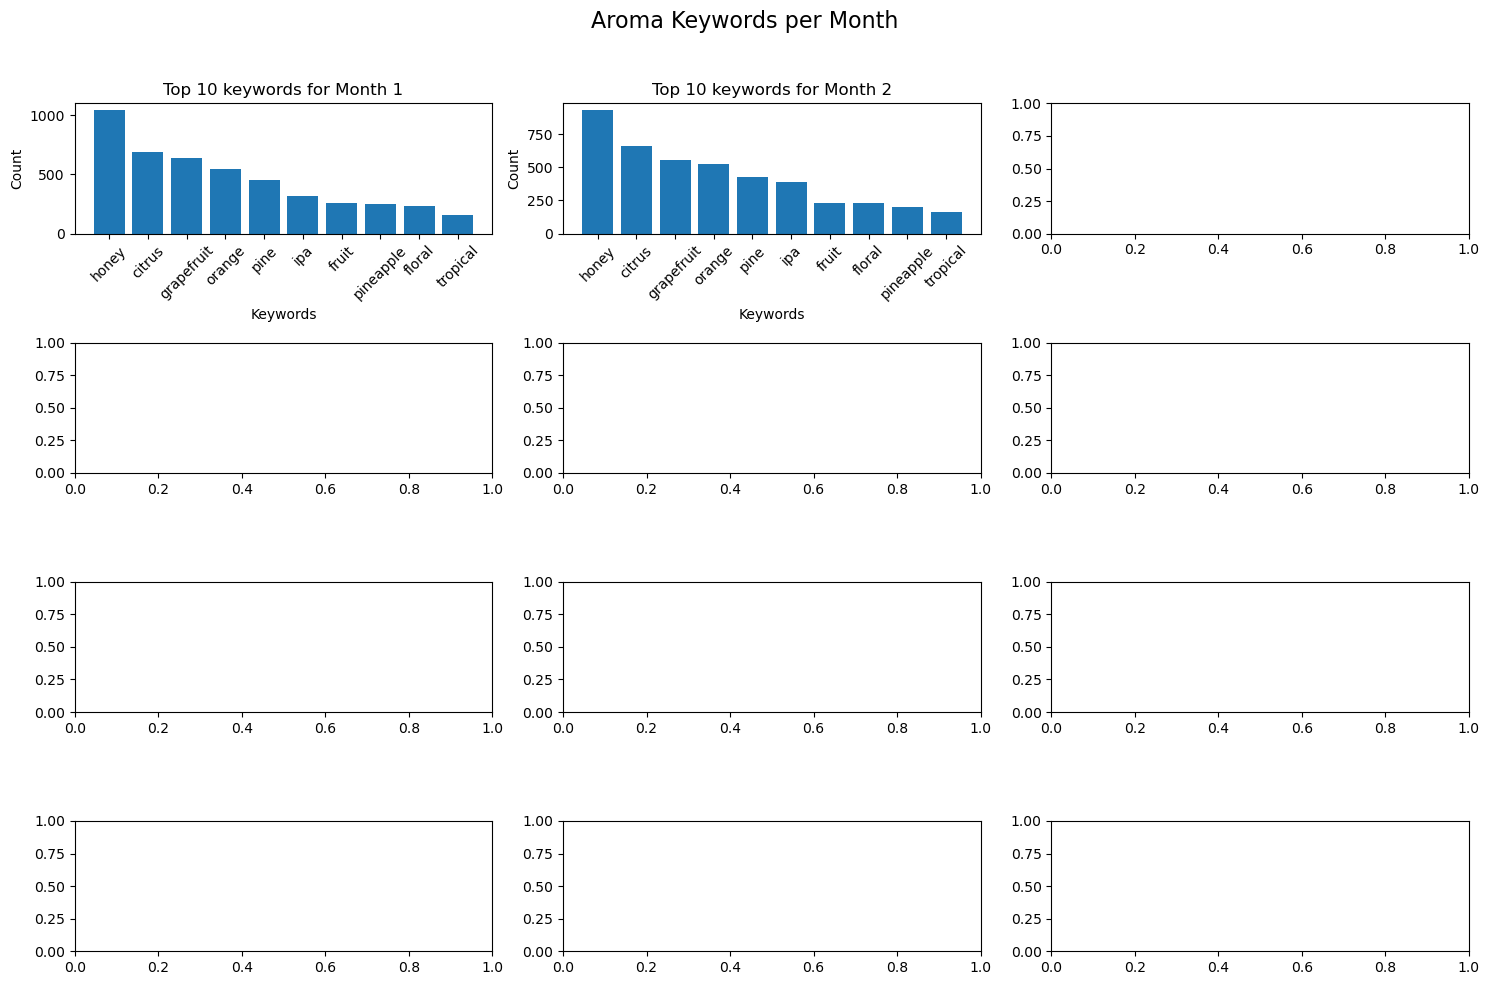

In [36]:
# Create a 3x4 grid of subplots
fig, axes = plt.subplots(4, 3, figsize=(15, 10))
fig.suptitle('Aroma Keywords per Month', fontsize=16)

# Flatten the 3x4 subplot grid into a 1D array for iteration
axes = axes.flatten()

# Iterate over each key and create a subplot
for i, (key, data) in enumerate(top_keywords_by_month.items()):
    keywords, values = zip(*data)

    # Create a bar plot on the current subplot
    axes[i].bar(keywords, values)
    axes[i].set_title(f'Top 10 keywords for Month {key}')
    axes[i].set_xlabel('Keywords')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [48]:
# Analysis for the bad beers
bad_top_keywords_by_month = {}
for month in range(1, 13):
    bad_top_keywords_by_month[month] = find_top_keywords_by_month(good_ratings_combined_df, aroma_terms, month, 'aroma', 10, True)
    #print("Month", month)
    #print(top_keywords_by_month[month])
    #print()

True
       beer_id     aroma  count  above_average  below_average   lower_bound
25990   103990  4.452381     21              0             21 -1.173174e-17
491        635  4.154762     21              0             21 -1.173174e-17
3105      5643  3.916667     21              0             21 -1.173174e-17
30704   134356  4.476190     21              0             21 -1.173174e-17
489        633  4.261905     21              0             21 -1.173174e-17
16165    57110  4.154762     21              0             21 -1.173174e-17
488        632  4.130952     21              0             21 -1.173174e-17
1211      1670  3.952381     21              0             21 -1.173174e-17
19399    72465  4.345238     21              0             21 -1.173174e-17
11168    36782  4.440476     21              0             21 -1.173174e-17
True
       beer_id     aroma  count  above_average  below_average   lower_bound
13997    52718  4.142857     21              0             21 -1.173174e-17
26

True
       beer_id     aroma  count  above_average  below_average   lower_bound
13584    50795  4.261905     21              0             21 -1.173174e-17
12695    46188  3.964286     23              0             21 -1.173174e-17
13341    49472  4.273810     22              0             21 -1.173174e-17
10874    38776  4.047619     21              0             21 -1.173174e-17
15036    56761  4.261905     21              0             21 -1.173174e-17
17174    66674  4.238095     22              0             21 -1.173174e-17
43050   241733  4.392857     21              0             21 -1.173174e-17
6993     19186  4.095238     21              0             21 -1.173174e-17
31752   155168  4.357143     21              0             21 -1.173174e-17
10421    36195  3.976190     21              0             21 -1.173174e-17
True
       beer_id     aroma  count  above_average  below_average   lower_bound
19193    75828  3.952381     21              0             21 -1.173174e-17
30

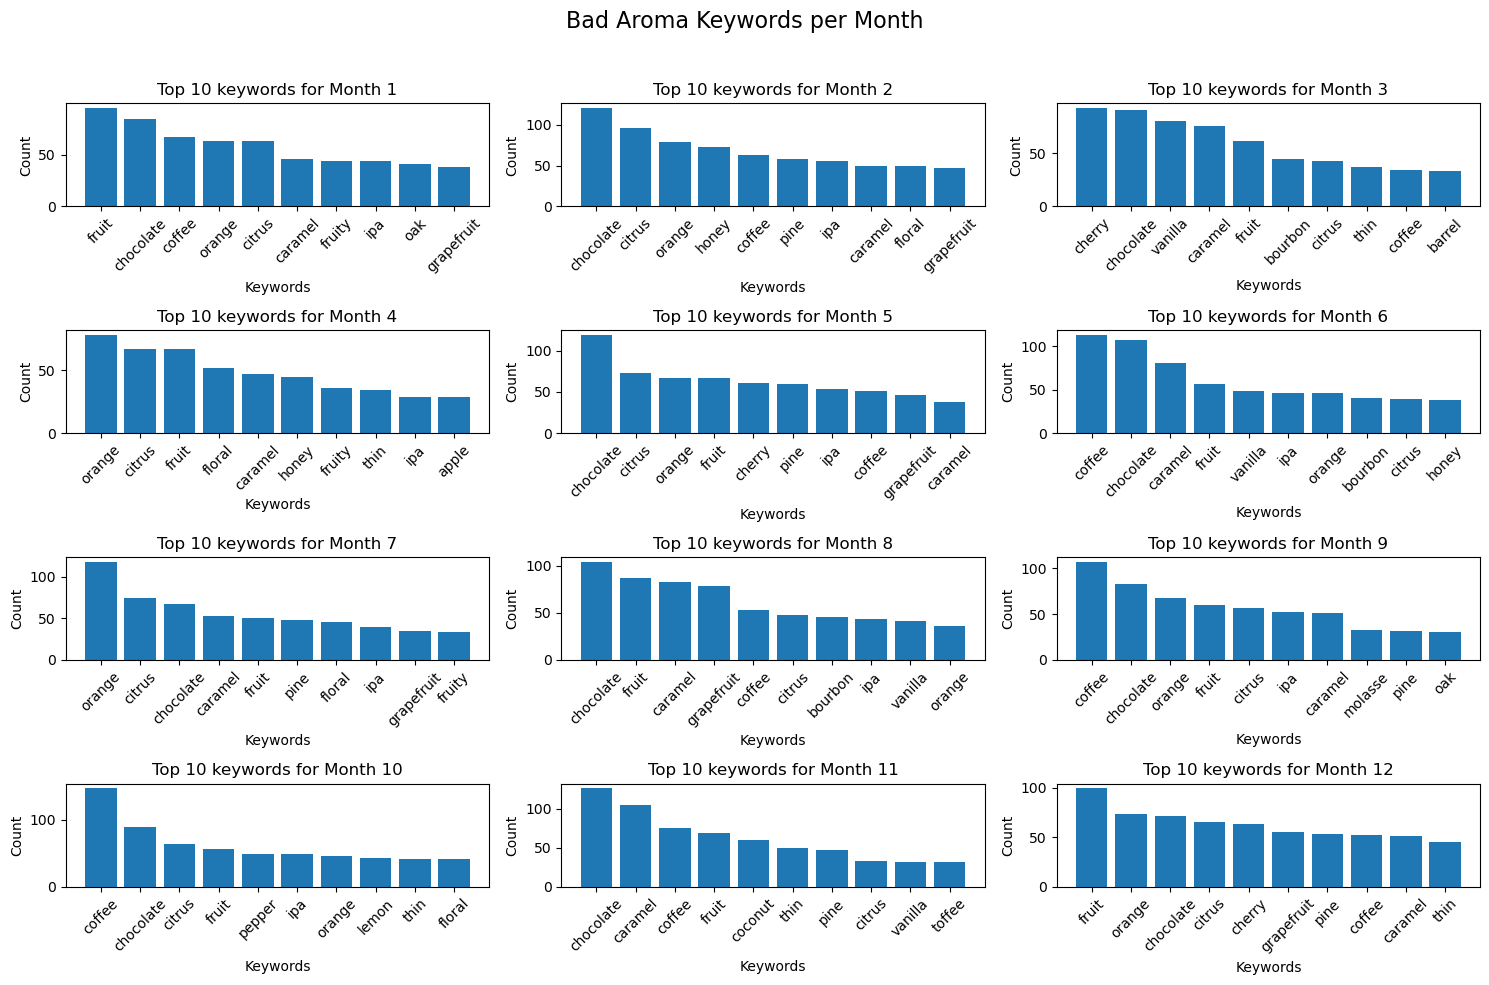

In [49]:
# Create a 3x4 grid of subplots
fig, axes = plt.subplots(4, 3, figsize=(15, 10))
fig.suptitle('Bad Aroma Keywords per Month', fontsize=16)

# Flatten the 3x4 subplot grid into a 1D array for iteration
axes = axes.flatten()

# Iterate over each key and create a subplot
for i, (key, data) in enumerate(bad_top_keywords_by_month.items()):
    keywords, values = zip(*data)

    # Create a bar plot on the current subplot
    axes[i].bar(keywords, values)
    axes[i].set_title(f'Top 10 keywords for Month {key}')
    axes[i].set_xlabel('Keywords')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Taste analysis

In [ ]:
# for each month, find the top 10 keywords
top_keywords_by_month_taste = {}
for month in range(1, 13):
    top_keywords_by_month_taste[month] = find_top_keywords_by_month(good_ratings_combined_df, taste_terms, month, 'taste', 10)
    #print("Month", month)
    #print(top_keywords_by_month_taste[month])
    #print()

In [ ]:
# for each month, find the top 10 keywords
top_keywords_by_month_taste = {}
for month in range(1, 13):
    top_keywords_by_month_taste[month] = find_top_keywords_by_month_traditional(good_ratings_combined_df, taste_terms, month, 'taste', 10)
    #print("Month", month)
    #print(top_keywords_by_month_taste[month])
    #print()

## Palate analysis 

In [ ]:
# for each month, find the top 10 keywords
top_keywords_by_month_palate = {}
for month in range(1, 13):
    top_keywords_by_month_palate[month] = find_top_keywords_by_month(good_ratings_combined_df, palate_terms, month, 'palate', 10)
    #print("Month", month)
    #print(top_keywords_by_month_palate[month])
    #print()

## Appearance analysis

In [ ]:
# for each month, find the top 10 keywords
top_keywords_by_month_appearance = {}
for month in range(1, 13):
    top_keywords_by_month_appearance[month] = find_top_keywords_by_month(good_ratings_combined_df, appearance_terms, month, 'appearance', 10)
    #print("Month", month)
    #print(top_keywords_by_month_appearance[month])
    #print()